In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import packages
from keras.layers import Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# visualization
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

def myscatter(Y, class_idxs, legend=False, ran=True, seed=229):
    if ran:
        np.random.seed(seed)
    Y = np.array(Y)
    fig, ax = plt.subplots(figsize=(6,4), dpi=300)
    classes = list(np.unique(class_idxs))
    markers = 'osD' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if ran:
        np.random.shuffle(colors)

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(Y[class_idxs == cls, 0], Y[class_idxs == cls, 1], marker=mark,
                linestyle='', ms=4, label=str(cls), alpha=1, color=colors[i],
                markeredgecolor='black', markeredgewidth=0.15)
    if legend:
        ax.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0, fontsize=10, markerscale=2, frameon=False,
                  ncol=2, handletextpad=0.1, columnspacing=0.5)

    plt.xticks([])
    plt.yticks([])

    return ax

In [ ]:
# t-SNE
def tsne(X, dim=2, ran=23):
    t_sne = TSNE(n_components=dim, random_state=ran)
    Y_tsne = t_sne.fit_transform(X)
    return Y_tsne

In [ ]:
pip install phenograph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install hyperopt

In [ ]:
# define an objective function hyperopt
def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2

# define a search space
from hyperopt import hp
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

In [ ]:
# clustering layer

from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.keras.backend as K
import phenograph
from sklearn.cluster import KMeans

class ClusteringLayer(Layer):
    def __init__(self, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=None, initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def target_distribution(q):
    q = q.numpy()
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def computeCentroids(data, labels):
    n_clusters = len(np.unique(labels))
    return np.array([data[labels == i].mean(0) for i in range(n_clusters)])

def get_centers(H, mode="kmeans", n_cluster=10):
    if mode == "louvain":
        l, _,  _ = phenograph.cluster(H)
    elif mode == "kmeans":
        l = KMeans(n_clusters=n_cluster, random_state=0).fit(h).labels_
    centers = computeCentroids(H, l)
    return centers, l

In [ ]:
# read data
cells_number = np.array(pd.read_csv("/content/drive/My Drive/RNN/BM4_celltype_number.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/RNN/BM4_normalize.csv", index_col=0, sep=","))

In [ ]:
# read data
cells_number = np.array(pd.read_csv("/content/drive/My Drive/RNN/Old/AML707B-all_celltype_number.csv", index_col=0, sep="\t"))
cells = np.array(pd.read_csv("/content/drive/My Drive/RNN/Old/AML707B-all_celltype_sample.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/RNN/Old/AML707B-all_normalize.csv", index_col=0, sep=","))

In [ ]:
cells_number

array([ 0,  1,  2, ...,  4,  4, 10])

In [ ]:
count

array([[0.        , 0.        , 0.        , ..., 0.23211671, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
count.shape

(3738, 19566)

In [ ]:
count.T

In [ ]:
# read data
cells = np.array(pd.read_csv("/content/drive/My Drive/RNN/AML707B-D41.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/RNN/AML707B-D41.csv", index_col=0, sep="\t"))

In [ ]:
count = np.array(pd.read_csv("AML-029-08-1E_data.csv", index_col=0, sep="\t"))

In [ ]:
# read data
cells = np.array(pd.read_csv("/content/drive/My Drive/CompBio/test_data/GSM3587969_AML707B-D0_info_new.csv", index_col=0, sep="\t"))
cells_number = np.array(pd.read_csv("/content/drive/My Drive/CompBio/test_data/GSM3587969_AML707B-D0_info_number.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/CompBio/test_data/GSM3587969_AML707B-D0_normalize.csv", index_col=0, sep=","))

In [ ]:
# preprocessing
[n_sample, n_gene] = count.shape

x_train = count.astype('float32')
cells_number=cells_number.flatten()

In [ ]:
from tensorflow.keras.losses import MSE, KLD
from keras.constraints import NonNeg
class AE(tf.keras.Model):

    def __init__(self, X, hidden_dim=[], latent_dim=50, impute_dim=64):
        super(AE, self).__init__()
        self.X = X

        # encoder
        
        #encoder_in = Input(shape=n_gene)
        #encoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(encoder_in)
        #encoded2 = Dense(latent_dim, activation = "relu", use_bias=True)(encoded1)
        #kernel_constraint=NonNeg(), 
        #kernel_initializer='glorot_uniform'
        
        encoder_in = Input(shape=n_gene)
        if len(hidden_dim) == 0:
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoder_in)
        elif len(hidden_dim) == 1:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        elif len(hidden_dim) == 2:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(hidden_dim[1], activation = "relu", use_bias=True)(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        else:
            encoded_list = []
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded_list.append(encoded)
            for i in range(1, len(hidden_dim)-1):
                encoded = Dense(hidden_dim[i], activation = "relu", use_bias=True)(encoded_list[i-1])
                encoded_list.append(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded_list[-1])
        encoder = Model(inputs=encoder_in, outputs=encoded, name="encoder")
    
        self.encoder = encoder
    
        # decoder
        
        #decoder_in = Input(shape=latent_dim)
        #decoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(decoder_in)
        #decoded2 = Dense(n_gene, activation = "relu", use_bias=True)(decoded1)
        #decoder = Model(inputs=decoder_in, outputs=decoded2, name="decoder")
        
        hidden_rev = hidden_dim[::-1]
        decoder_in = Input(shape=latent_dim)
        if len(hidden_dim) == 0:
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoder_in)
        elif len(hidden_dim) == 1:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        elif len(hidden_dim) == 2:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(hidden_rev[1], activation = "relu", use_bias=True)(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        else:
            decoded_list = []
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded_list.append(decoded)
            for i in range(1, len(hidden_rev)-1):
                decoded = Dense(hidden_rev[i], activation = "relu", use_bias=True)(decoded)
                decoded_list.append(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded_list[-1])
        decoder = Model(inputs=decoder_in, outputs=decoded, name="decoder")
    
        self.decoder = decoder
    
        # imputer
        impute_in = Input(shape=n_gene)
        imputed1 = Dense(impute_dim, activation = "relu")(impute_in)
        imputed2 = Dense(n_gene, activation = "relu")(imputed1)
        imputer = Model(inputs=impute_in, outputs=imputed2, name="imputer")
    
        impute_mask = np.zeros([n_sample, n_gene])
        for i in range(n_sample):
            for j in range(n_gene):
                if count[i,j] == 0:
                    impute_mask[i,j] = 1
        self.mask = tf.convert_to_tensor(impute_mask, dtype=tf.float32)
    
        self.imputer = imputer
    
        # clustering
        clustering_layer = ClusteringLayer(name='clustering')(encoded)
        clustering_model = Model(inputs=encoder_in, outputs=clustering_layer, name="cluster")
    
        self.clustering = clustering_model
    
    # pre-training
    def train(self, T=2, max_epoch=100, learning_rate=0.0001):
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            with tf.GradientTape(persistent=True) as tape:
                
                x = self.X
                loss = 0
                
                for t in range(T):
                    h = self.encoder(x)
                    y = self.decoder(h)
                    
                    v = self.imputer(y)
                    x = self.X + tf.multiply(self.mask, v)
                    
                    loss += tf.reduce_mean(MSE(self.X, y))
                    
                if loss / T < 0.5:
                    break;

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 5 == 0:
                print(loss)
        print("Finish!")
        
    # clustering training
    def clustering_train(self, centers, wc=2.5, max_epoch=30, learning_rate=0.0001):
        
        self.clustering.get_layer(name='clustering').clusters = centers
        
        q = self.clustering(x_train)
        p = target_distribution(q)
        
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            if epoch % 10 == 0:
                #centers, labels = get_centers(np.array(h), mode=mode, n_cluster=n_cluster)
                #self.clustering.get_layer(name='clustering').clusters = centers
                q = self.clustering(self.X)
                p = target_distribution(q)
            with tf.GradientTape(persistent=True) as tape:
                
                h = self.encoder(self.X)
                y = self.decoder(h)
                    
                loss = tf.reduce_mean(MSE(self.X, y))
                
                q_out = self.clustering(self.X)
                
                #if epoch % 10 == 0:
                    #print(q_out)
                
                cluster_loss = tf.reduce_mean(KLD(q_out, p))
                loss += wc * cluster_loss

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 10 == 0:
                print(loss)
                print(cluster_loss)
        print("Finish!")

In [ ]:
autoencoder = AE(x_train, hidden_dim=[1000], latent_dim=50, impute_dim=64)

In [ ]:
autoencoder.train(T=2, max_epoch=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


tf.Tensor(5.467153, shape=(), dtype=float32)
tf.Tensor(5.2687297, shape=(), dtype=float32)
tf.Tensor(4.9220753, shape=(), dtype=float32)
tf.Tensor(4.4437923, shape=(), dtype=float32)
tf.Tensor(3.9946938, shape=(), dtype=float32)
tf.Tensor(3.614067, shape=(), dtype=float32)
tf.Tensor(3.2632346, shape=(), dtype=float32)
tf.Tensor(2.941462, shape=(), dtype=float32)
tf.Tensor(2.6843786, shape=(), dtype=float32)
tf.Tensor(2.5267892, shape=(), dtype=float32)
tf.Tensor(2.4386442, shape=(), dtype=float32)
tf.Tensor(2.381697, shape=(), dtype=float32)
tf.Tensor(2.3326125, shape=(), dtype=float32)
tf.Tensor(2.2924895, shape=(), dtype=float32)
tf.Tensor(2.2447984, shape=(), dtype=float32)
tf.Tensor(2.1892061, shape=(), dtype=float32)
tf.Tensor(2.134286, shape=(), dtype=float32)
tf.Tensor(2.080268, shape=(), dtype=float32)
tf.Tensor(2.0262804, shape=(), dtype=float32)
tf.Tensor(1.9748478, shape=(), dtype=float32)
Finish!


In [ ]:
h = autoencoder.encoder(x_train)

In [ ]:
ed = tsne(h)  #Y

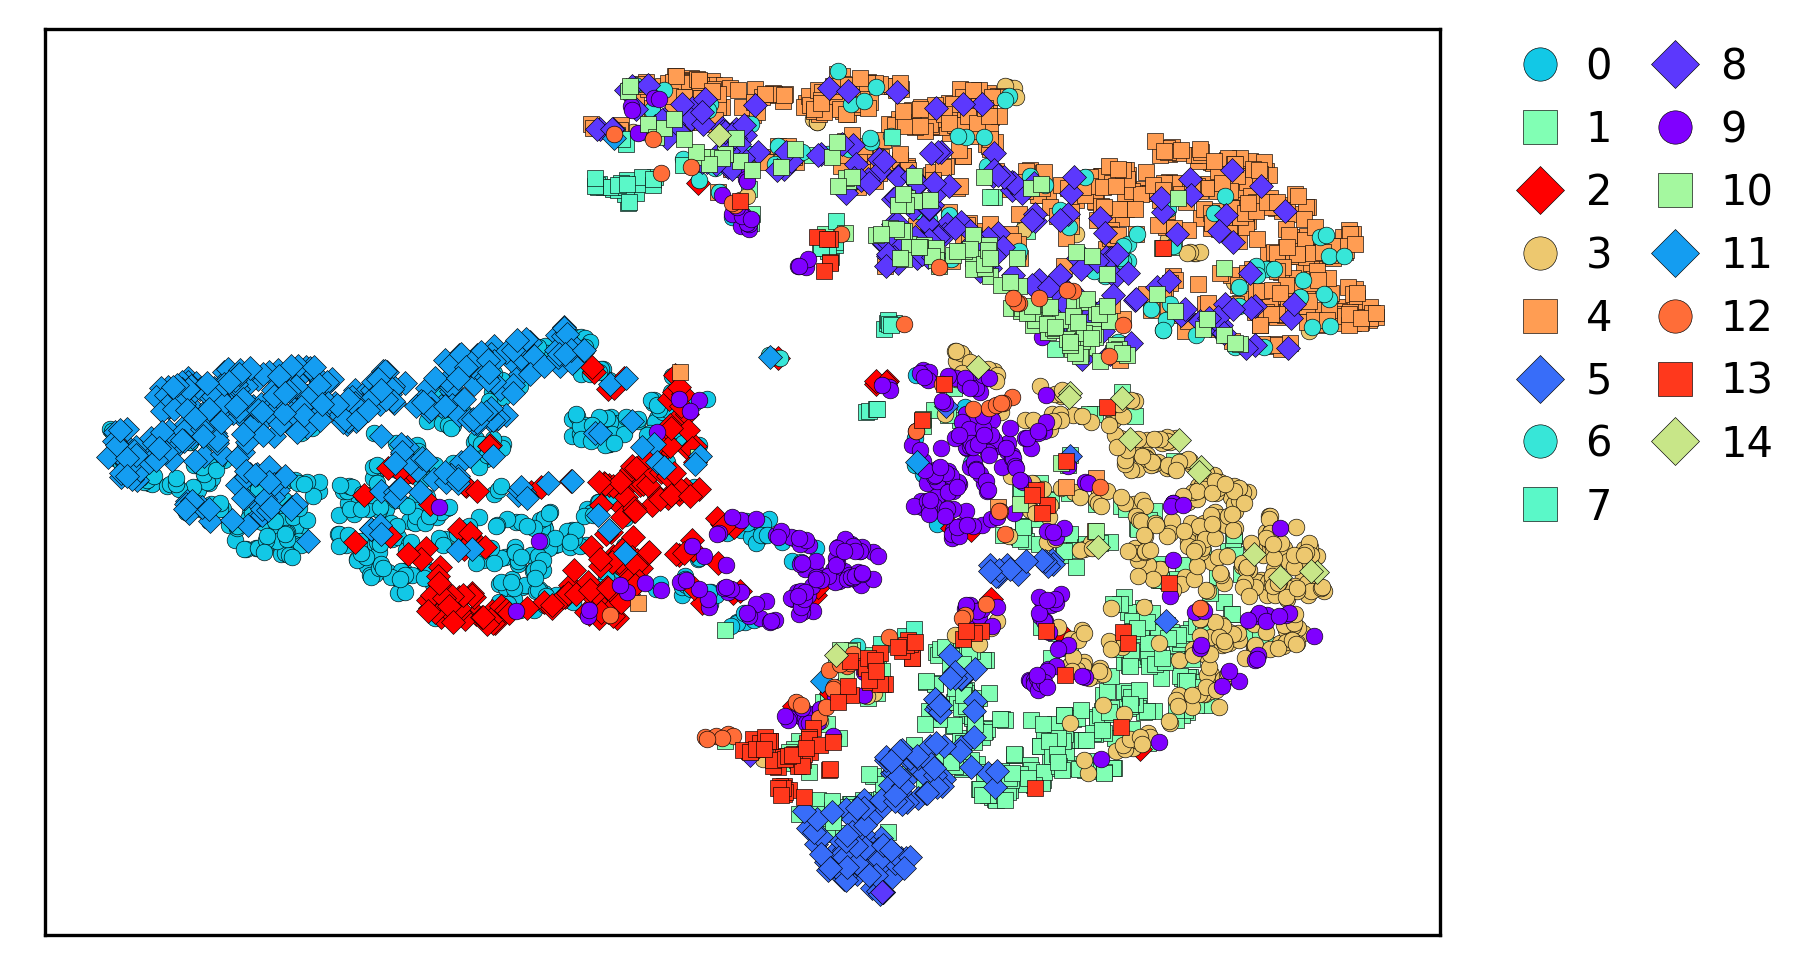

In [ ]:
myscatter(ed, cells_number, legend=True)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6216063499450684 seconds
Jaccard graph constructed in 1.1879067420959473 seconds
Wrote graph to binary file in 0.07193255424499512 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.82897
After 2 runs, maximum modularity is Q = 0.830325
After 18 runs, maximum modularity is Q = 0.831404
Louvain completed 38 runs in 3.4044911861419678 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.565572738647461 seconds


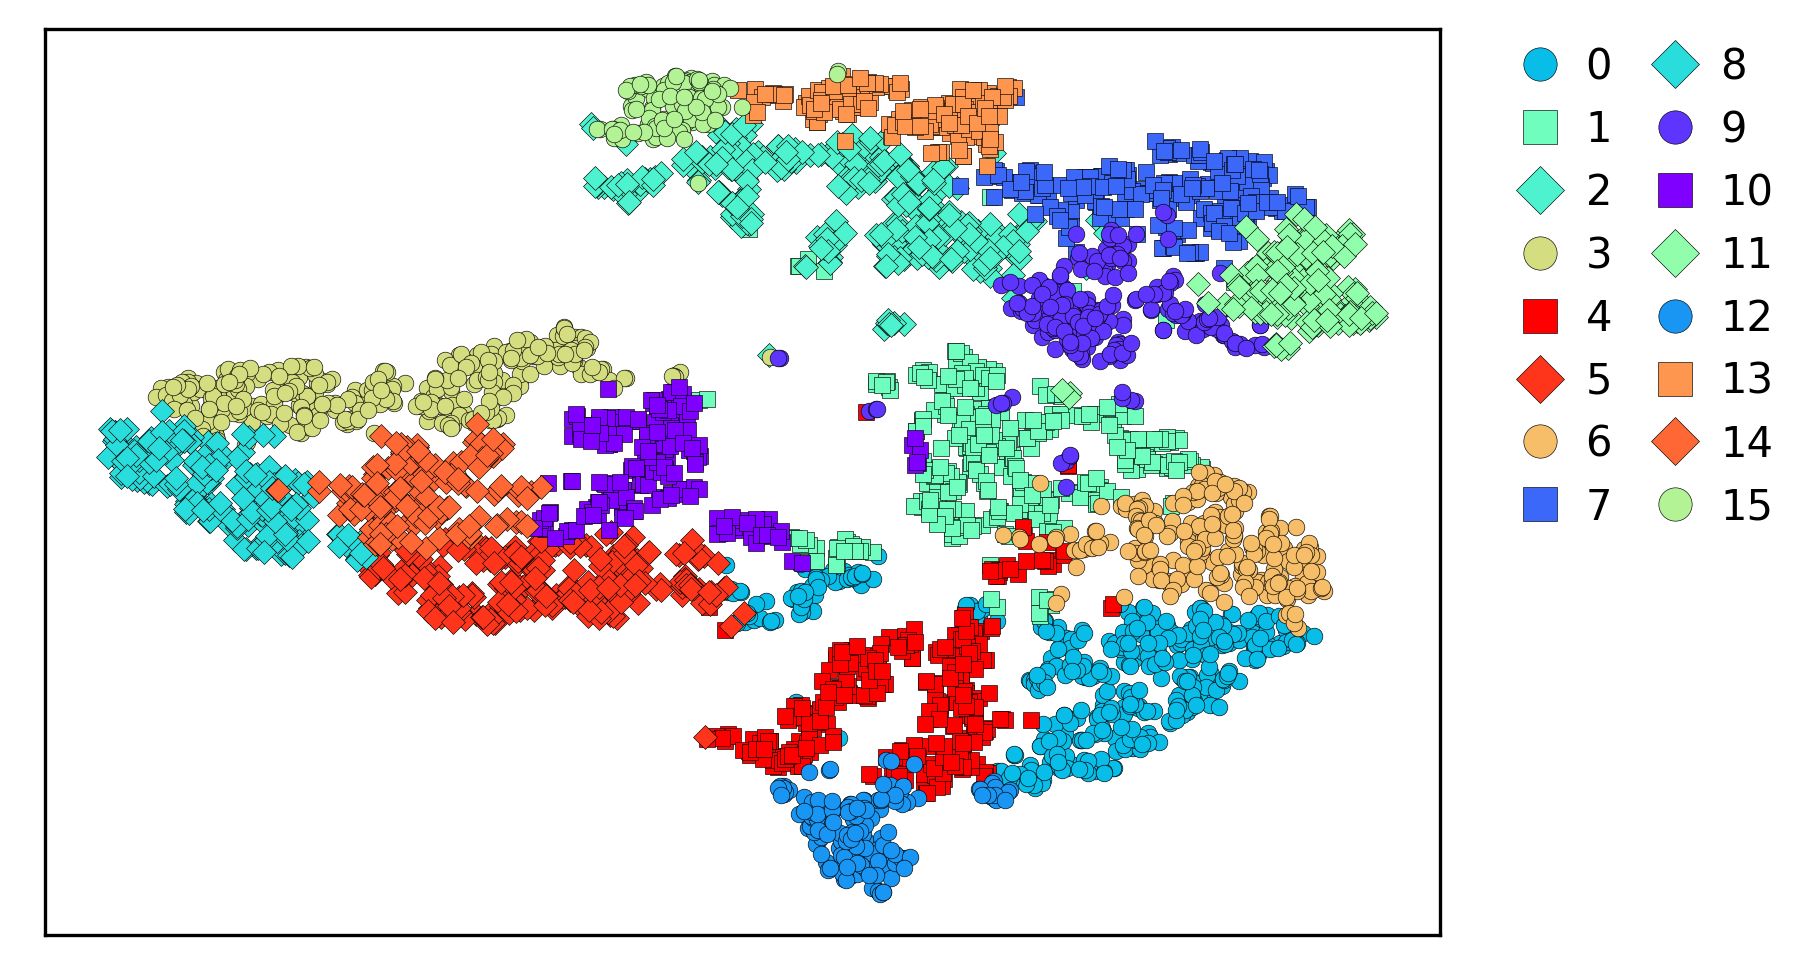

In [ ]:
centers, labels = get_centers(np.array(h), mode="louvain", n_cluster=5)
myscatter(ed,labels, legend=True)

In [ ]:
autoencoder.clustering_train(centers, wc=5, max_epoch=30)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


tf.Tensor(3.3269978, shape=(), dtype=float32)
tf.Tensor(0.46174794, shape=(), dtype=float32)
tf.Tensor(3.27601, shape=(), dtype=float32)
tf.Tensor(0.45727816, shape=(), dtype=float32)
tf.Tensor(3.1656945, shape=(), dtype=float32)
tf.Tensor(0.43983772, shape=(), dtype=float32)
Finish!


In [ ]:
h = autoencoder.encoder(x_train)

In [ ]:
ed = tsne(h)

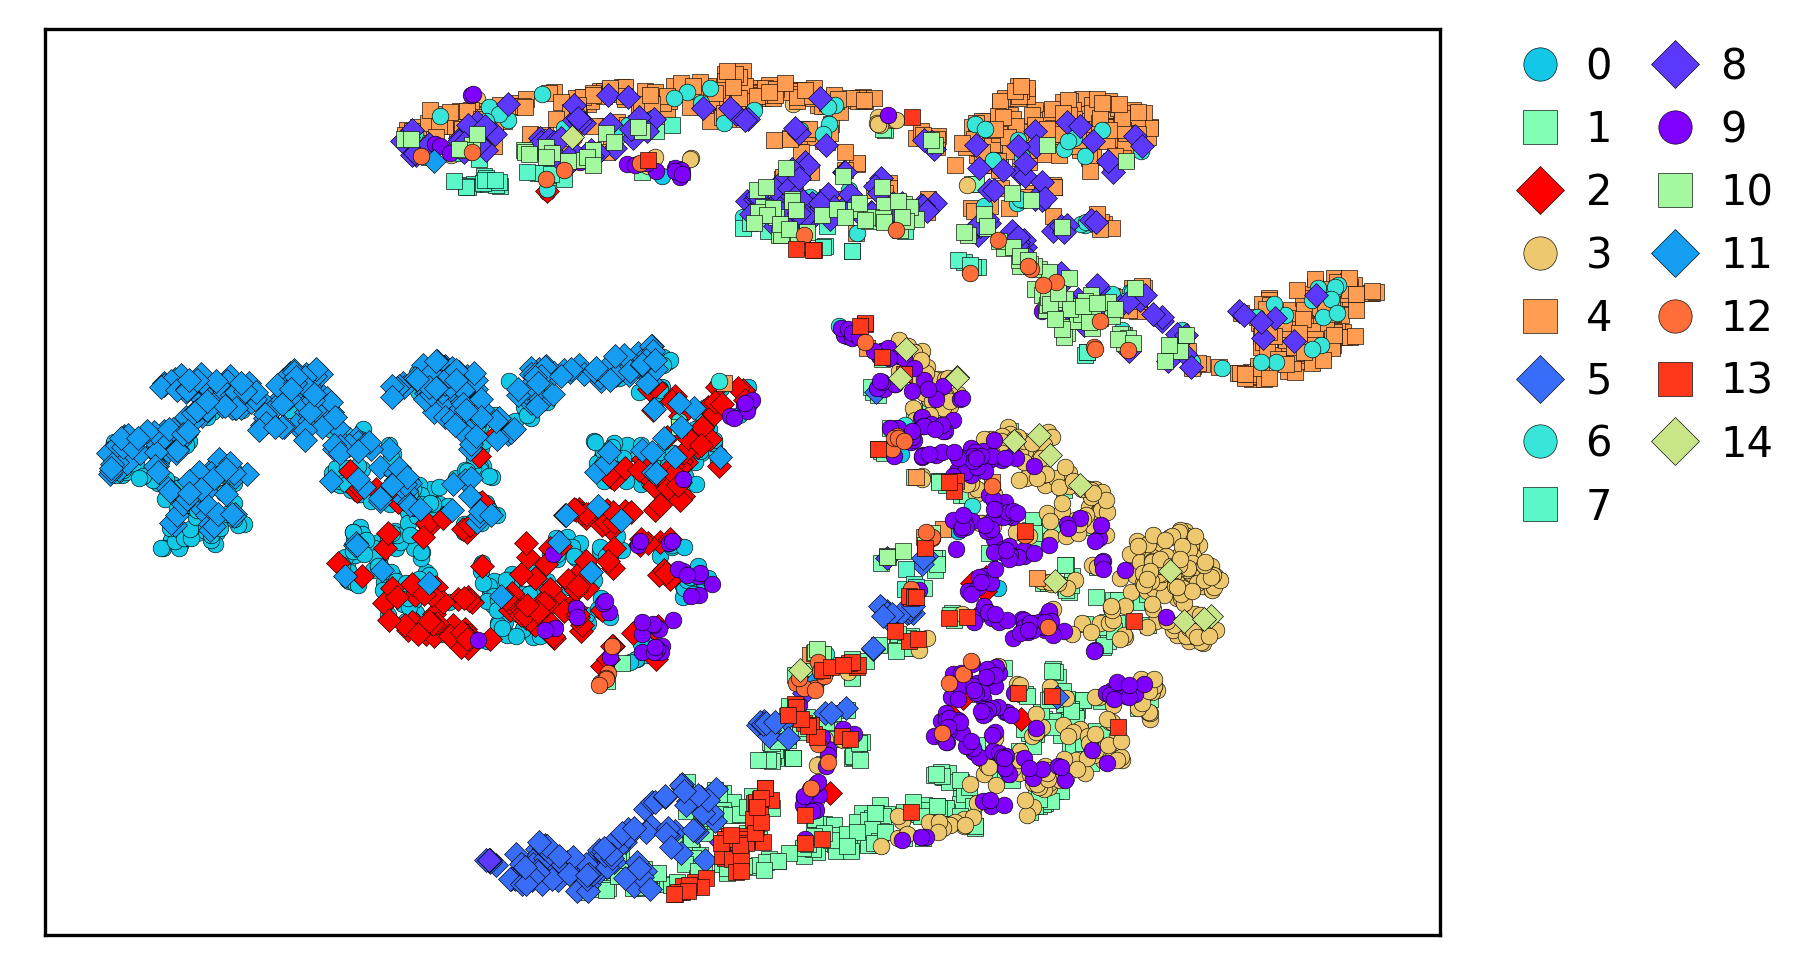

In [ ]:
myscatter(ed, cells_number, legend=True)

In [ ]:
ed = tsne(count) #n
myscatter(ed, cells_number, legend=True)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score
def measure(true, pred):
    NMI = round(normalized_mutual_info_score(true, pred), 2)
    RAND = round(adjusted_rand_score(true, pred), 2)
    HOMO = round(homogeneity_score(true, pred), 2)
    COMP = round(completeness_score(true, pred), 2)
    return [NMI, RAND, HOMO, COMP]

In [ ]:
labels_new, _,  _ = phenograph.cluster(np.array(h))
measure(cells_number, labels)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6217710971832275 seconds
Jaccard graph constructed in 1.6096985340118408 seconds
Wrote graph to binary file in 0.08094120025634766 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.883513
After 12 runs, maximum modularity is Q = 0.884966
Louvain completed 32 runs in 2.68986177444458 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.212153673171997 seconds


[0.49, 0.27, 0.52, 0.47]

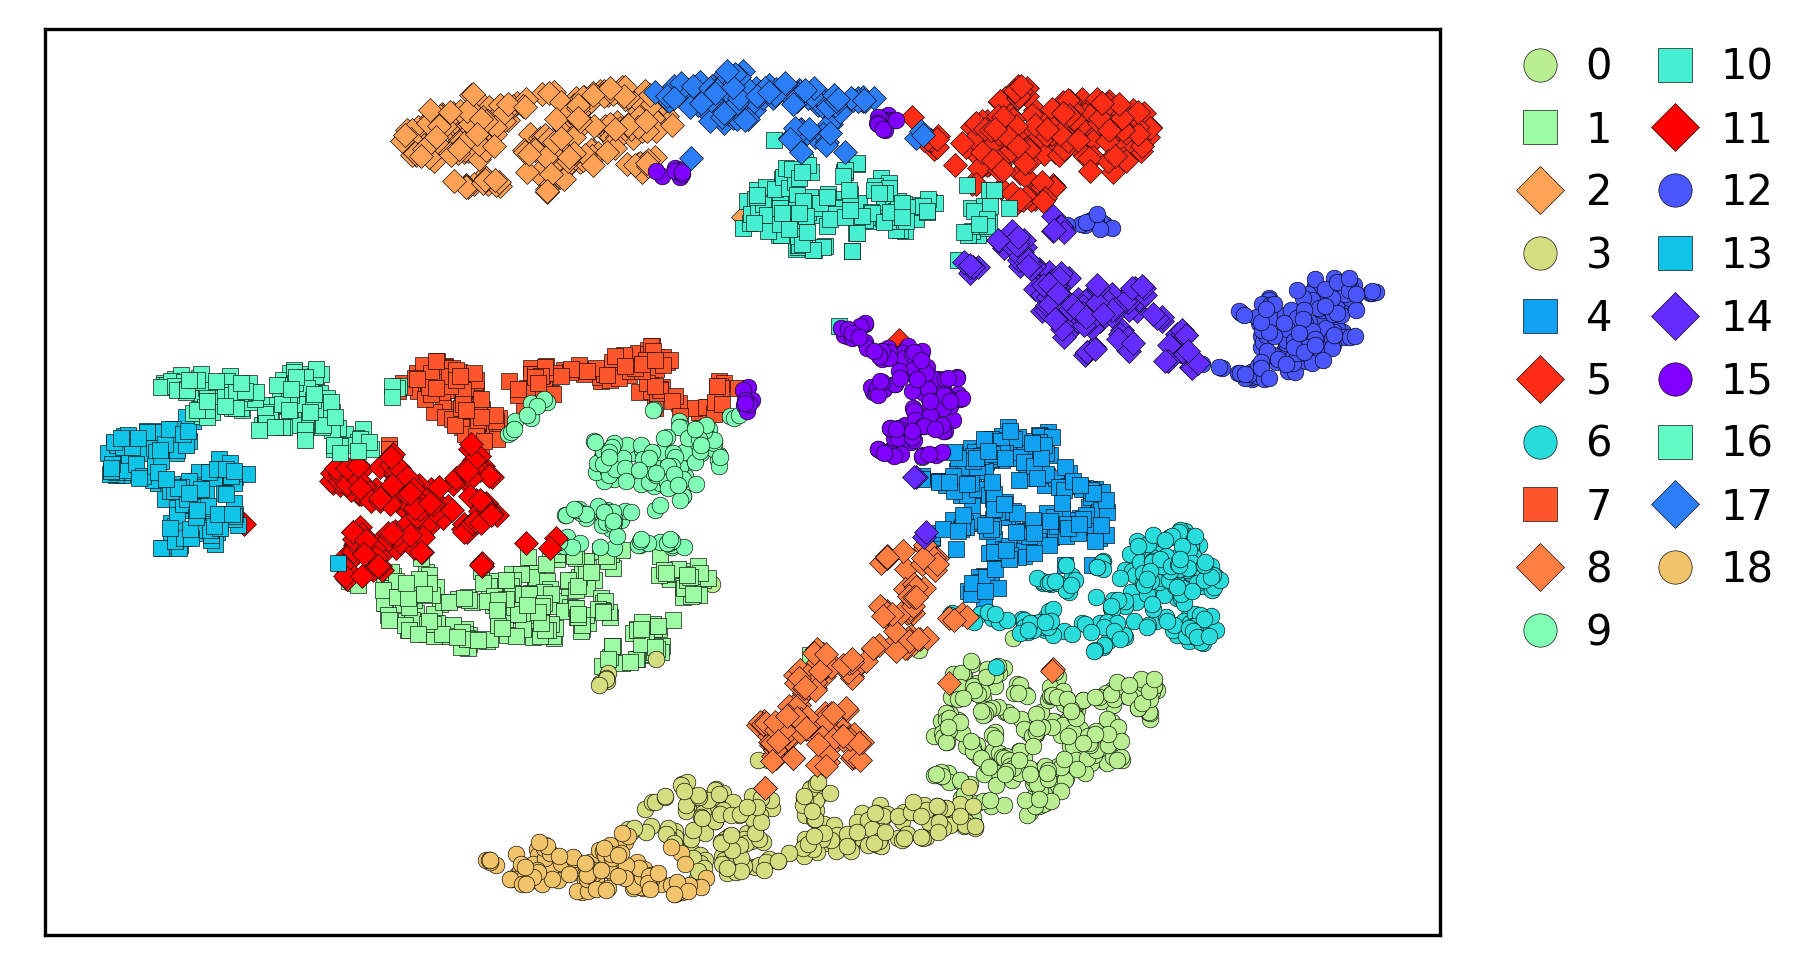

In [ ]:
myscatter(ed, labels_new, legend=True)

In [ ]:
labels_new = KMeans(n_clusters=10, random_state=0).fit(np.array(h)).labels_
measure(cells_number, labels)

[0.49, 0.27, 0.52, 0.47]

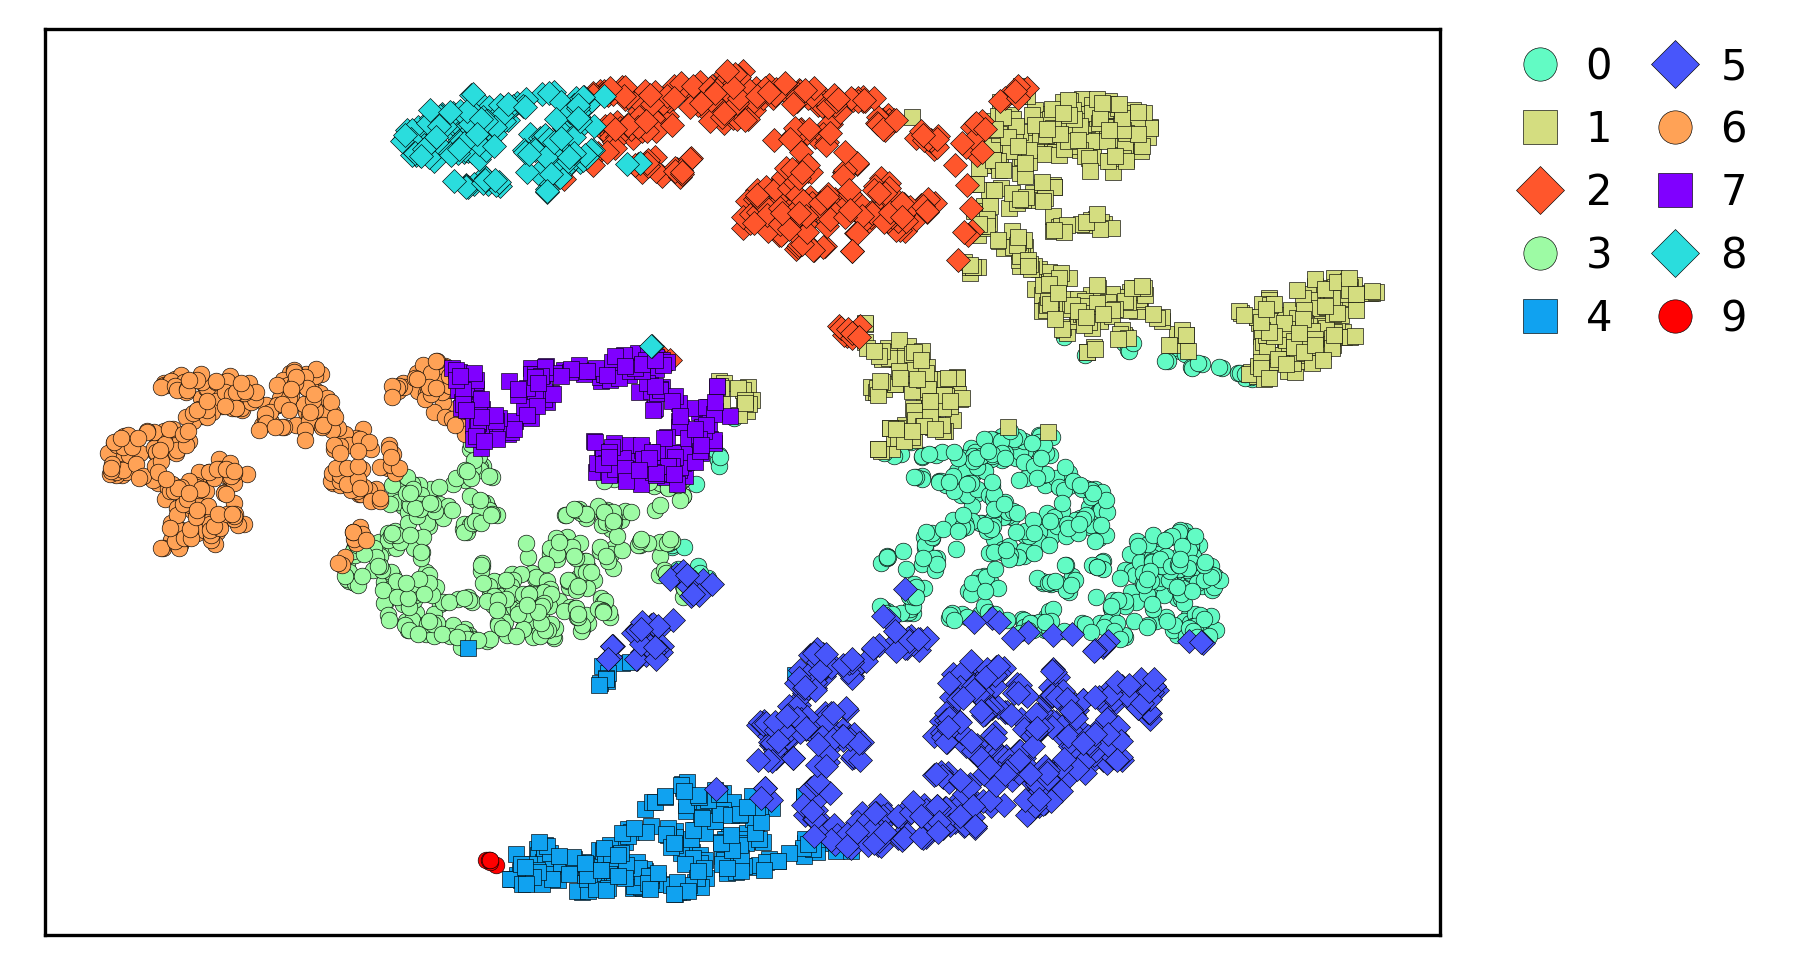

In [ ]:
myscatter(ed,labels_new, legend=True)

In [ ]:
save = pd.DataFrame(dist_mat)
save.to_csv('/content/drive/My Drive/RNN/AML7075-all_dist.csv',index=False,header=True)

In [ ]:
cells_label

In [ ]:
myscatter(ed,cells_label)

In [ ]:
save = pd.DataFrame(cf_matrix)
save.to_csv('/content/drive/My Drive/RNN/AML7075-all_matrix.csv',index=False,header=True)

In [ ]:
save = pd.DataFrame(labels_new)
save.to_csv('/content/drive/My Drive/RNN/BM4_predict.csv',index=False,header=True)

In [ ]:
save = pd.DataFrame(ed)
save.to_csv('/content/drive/My Drive/RNN/BM4_cluster.csv',index=False,header=True)

In [ ]:
print(type(cells_number)

In [ ]:
from scipy.spatial.distance import cdist
dist_mat = cdist(h, h, 'euclidean')

In [ ]:
y_test = cells_number
y_pred = labels_new

In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[ 14   6   4 224   1  14 143  98   1   0   0   0   0   0   0]
 [ 62  14   7   0 110 218   0   0   0   0   0   0   0   0   0]
 [  4   4   0 150   2  14   5  36   1   0   0   0   0   0   0]
 [233  43  16   0   1 128   0   0   3   0   0   0   0   0   0]
 [ 16 314 198   0   0   2   0   0  75   0   0   0   0   0   0]
 [ 15   1   0   0 119  19   0   0   0   6   0   0   0   0   0]
 [  4  48  26   0   0   1   0   1  15   0   0   0   0   0   0]
 [  4   7  14   0   0   1   0   0  28   0   0   0   0   0   0]
 [  5  75  92   0   1   1   0   0  40   1   0   0   0   0   0]
 [127  42  18  15   5 136   0   1   7   0   0   0   0   0   0]
 [ 11  62  49   0   0   4   0   1  16   0   0   0   0   0   0]
 [  1   0   1  33   0   1 257  99   3   0   0   0   0   0   0]
 [  8  15   2   0   5  16   0   0   6   0   0   0   0   0   0]
 [ 12   6   5   0  44  30   0   0   0   0   0   0   0   0   0]
 [  9   4   0   0   0   1   0   0   1   0   0   0   0   0   0]]


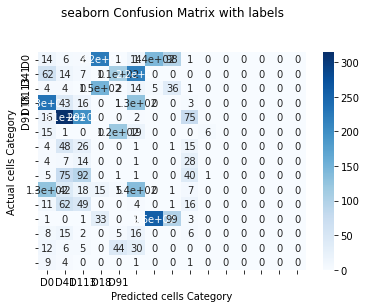

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')


ax.set_title('seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted cells Category')
ax.set_ylabel('Actual cells Category');
##Ticker labels-List must be in alphabetical order
ax.xaxis.set_ticklabels(['D0','D41','D113','D18','D91'])
ax.yaxis.set_ticklabels(['D0','D41','D113','D18','D91'])

##Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.023274478330658106